# Rabbit-Fox-Hawk
3D로 된 땅에 토끼(Rabbit), 여우(Fox), 매(Hwak), 풀(Grass)가 있다.
이 들 간의 먹이사슬이 있고 번식을 할 때 어떤 상황이 발생 하는지 시뮬레이션 한다.

동작환경:
* Julia v1.8.3
* Agents v5.6.2
* InteractiveDynamics v0.21.11
* CairoMakie v0.8.13
* GLMakie v0.6.13

참고 source : https://github.com/mrchaos/Agents.jl/blob/org/examples/rabbit_fox_hawk.jl

## 규칙
### 토끼(Rabbit)
* 토끼는 자신의 위치에 있는 풀이 있으면 먹는다
* 토끼가 포식자를 볼 경우 달아 난다.
* 토끼가 도망가는 방향은 토끼의 시야에 있는 모든 포식자의 위치에 달려 있는데 토끼가 있는 위치에 가까울 수록 더 많은 영향을 미친다.
    * 영향도(힘)는 토끼와 포식자 간의 거리의 제곱에 반비례 하도록 한다 중력, 전자력의 세기가 거리의 제곱에 반비례 하는것 처럼
* 매 스텝 에너비소요량은 마지막 스텝 이후 경과한 시간에 해당 한다.
* 에너지가 0 이되면 죽는다
* 매 스텝마다 재생산의 기회를 갖는다.
* 토끼의 시야에 포식자가 없으면 무작위로 돌아 다닌다.

### 여우(Fox) / 매(Hawk)
* 여우/매는 토끼를 사냥하며 자신의 위치에서 단위 반경 이내의 토끼를 잡아먹는다.
* 매 스텝 에너비소요량은 마지막 스텝 이후 경과한 시간에 해당 한다.
* 에너지가 0 이되면 죽는다
* 매 스텝마다 재생산의 기회를 갖는다.
* 여우/매가 이미 어디론가 움직이지 않았다면 근처에 토끼가 있는지 살펴본다. 
* 토끼가 근처에 없다면 여우/매는 근처 임의의 위치로 이동할 경로를 찾는다. 
* 토끼가 근처에 있다면 임의의 토끼를 향한 경로를 찾는다.
* 정해진 경로를 따라 주어진 속도로 움직인다.

In [1]:
using LinearAlgebra

In [2]:
using Agents, Agents.Pathfinding
using Random
import ImageMagick
using FileIO: load
using PrettyPrint:pprintln

In [3]:
@agent Animal ContinuousAgent{3} begin
    type::Symbol # one of :rabbit, :fox or :hawk
    energy::Float64
end

In [4]:
fieldnames(Animal)

(:id, :pos, :vel, :type, :energy)

In [5]:
const v0 = (0.0, 0.0, 0.0) # velocity field는 사용되지 않음
Rabbit(id, pos, energy) = Animal(id, pos, v0, :rabbit, energy)
Fox(id, pos, energy) = Animal(id, pos, v0, :fox, energy)
Hawk(id, pos, energy) = Animal(id, pos, v0, :hawk, energy)
# The euclidean norm of a vector
eunorm(vec) = √sum(vec .^ 2)

eunorm (generic function with 1 method)

In [6]:
let
    v = (1,2,3)    
    eunorm(v),norm(v)
end

(3.7416573867739413, 3.7416573867739413)

### 환경은 고도맵에서 생성된다.
* 2D matrix 고도맵이고 각 포인트는 영역의 고도를 나타낸다.
 - 수면(`water_level`) 아래는 어떤 동물도 들어갈 수 없다.
 - `water_level`과 초원(`grass_level`) 사이의 평탄한 영역에는 모두 들어 갈 수 있다.
 - `grass_level`과 산악(`mountain_level`) 사이 영역에는 너무 높아 걸어 갈수 업지만 날아 갈 수 있다.
 - `mountain_level` 이상의 영역은 아무도 접근 할 수 없는 영역이다.

풀(Grass)는 토끼의 먹이 원천 이며 `water_level`과 `grass_level` 사이에서 자란다.

영역에 퍼져 있는 풀은 `BitArray`를 사용하여 표현한다. `BitArray`에서 1의 값은 풀이 있음을 표현하며 토끼가 먹을 수 있고 먹었을 때 소비되고 값은 0으로 바뀐다. 풀의 성장률(확률)은 수면에 가까이 다가갈 수록 높아 진다.

`initialize_model` function은 고도맵이 있는 url에서 다운로드하고 고도맵의 높이에 따라 영역을 나누고 토끼,여우,매를 모델에 추가하고 추가적인 파라미터를 모델에 추가 한다.


### 고도맵(Heightmap) 다운로드

In [7]:
# 고도맵 파일이 images 폴더에 없어면 다운로드 한다.
heightmap_path = "../img/rabbit_fox_hawk_heightmap.png"
let
    heightmap_url ="https://raw.githubusercontent.com/JuliaDynamics/" *
                    "JuliaDynamics/master/videos/agents/rabbit_fox_hawk_heightmap.png"
    !isfile(heightmap_path) && cp(download(heightmap_url),heightmap_path)
end

false

map (x,y) : (205, 205)


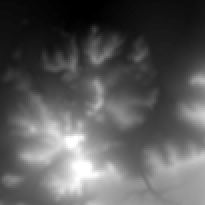

┌ Warning: Output swatches are reduced due to the large size (205×205).
│ Load the ImageShow package for large images.
└ @ Colors /home/shpark/.julia/packages/Colors/yDxFN/src/display.jl:159


In [8]:
let
    heightmap_path = "../img/rabbit_fox_hawk_heightmap.png"
    map = load(heightmap_path)
    println("map (x,y) : ", size(map))
    map
end

In [9]:
let
    map = load(heightmap_path)
    Float64.([minimum(map),maximum(map)])
end

2-element Vector{Float64}:
 0.0
 1.0

In [10]:
let
    ENV["DISPLAY"]="localhost:13.0"
    using Colors
    using Images
    using GLMakie
    GLMakie.activate!()
    
    
    fig = Figure(resolution=(800, 600))
    ax = Axis3(fig[1,1]; aspect=(1, 1, 1))

    # load function png파일에서 데이터를 바로 읽을 수 있다.
    # 고도맵의 높이를 1 ~ 40 까지 높이로 만든다.
    heightmap = floor.(Int,convert.(Float64,load(heightmap_path)) *39 ) .+ 1
    map_x,map_y = size(heightmap)
    hm =surface!(
        ax,
        (100/map_x):(100/map_x):100,
        (100/map_y):(100/map_y):100,
        heightmap;
        colormap = :terrain
        )
    display(fig)
end

GLMakie.Screen(...)

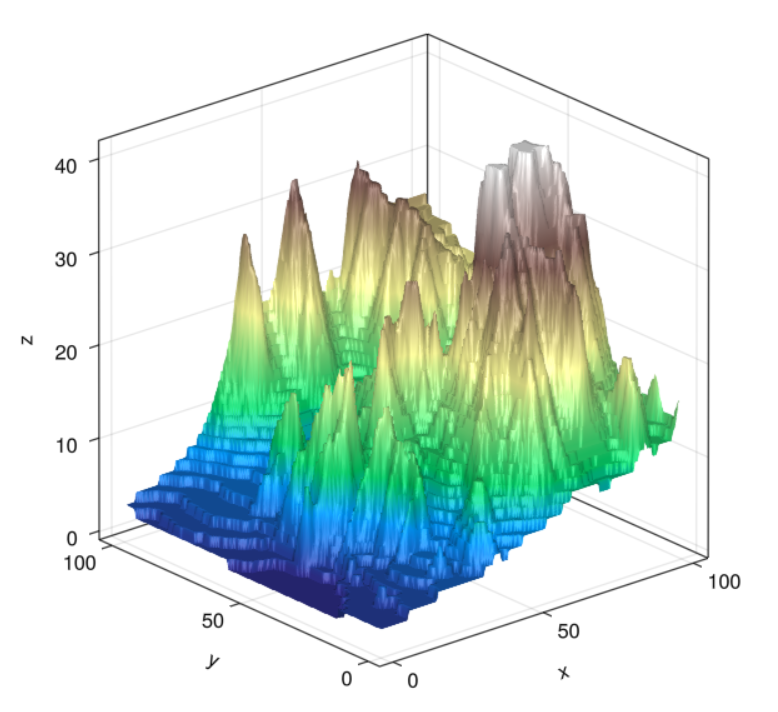

#### <font color=red>수면가까이에 있는 고도맵(heightmap)에 더 많은 확률로 풀이 자라는 것을 모델링</font>
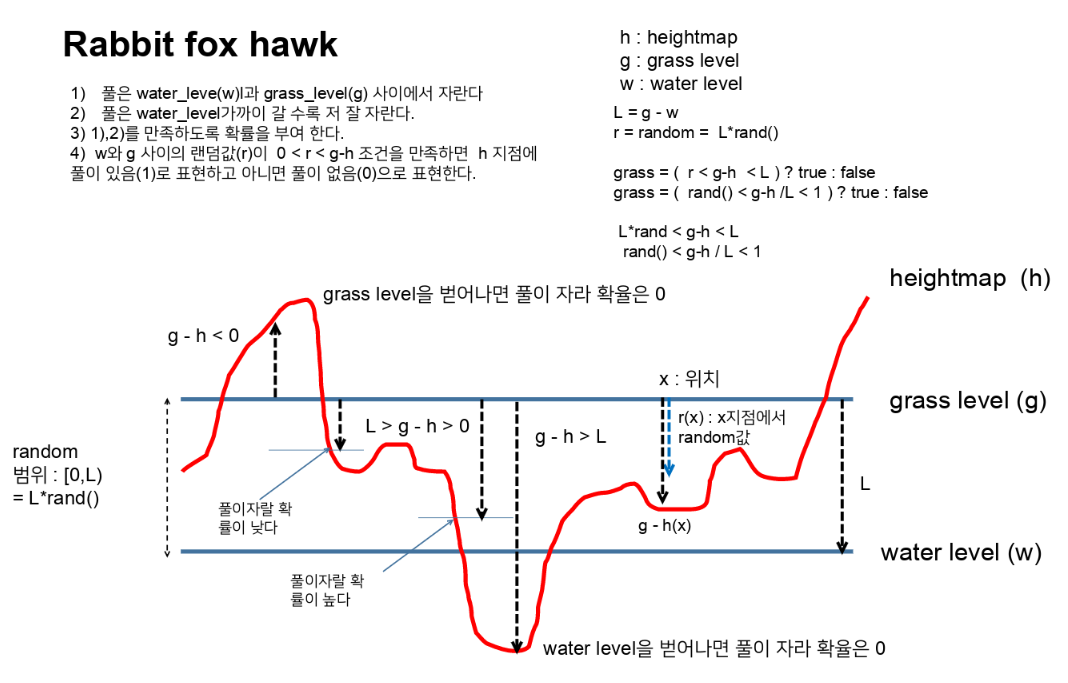

In [11]:
let
    rng = MersenneTwister(42)    
    water_level = 8
    grass_level = 20
    mountain_level = 35    
    heightmap = floor.(Int,convert.(Float64,load(heightmap_path)) *39 ) .+ 1
    dims = (size(heightmap)..., 50)
    # 범위 : [0,1)
    # 랜덤은 water_level과 grass_level사이의 값    
    r = rand(rng,dims[1:2]...)    
    L = grass_level - water_level
    # -----------------------------------------
    # 원소스에서는 아래식을 사용하는데 수면 아래에서는 무조건
    # 풀이 있는 것으로 표현되는데 `land_walkmap`에 의해
    # 토끼가 수면아래로 갈 수 없기 때문에 문제가 되지 않는다고 한다.
    # 하지만 더 정확하게 g2형태로 수면아래에서는 풀이 없는 것으로
    # 정확하게 표현하는 것이 좋다.
    # -----------------------------------------    
    g1 = r .< ((grass_level .- heightmap) ./ L)        
    # -----------------------------------------
    # g2 표현식이 더 정확하다.
    # -----------------------------------------
    g2 = r .< ( (grass_level.- heightmap) ./ L) .< 1
    
    display(heightmap)
    display(g1)    
    display(g2)
#     grass1 = BitArray(g1,)
#     grass2 = BitArray(g2,)
end

205×205 Matrix{Int64}:
  2   2   2   2   2   2   2   2   2  …   2   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2  …   3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   4   4   4
  2   2   2   2   2   2   2   2   2  …   3   3   3   3   3   3   4   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   4   4   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   4   4   4   4
  

205×205 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1 

205×205 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0 

In [12]:
let
    Tuple(zeros(Int,3))
end

(0, 0, 0)

### Neighbor
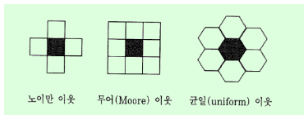

* moore_neighbor(D) :: astar.jl
* vonneumann_neighborhood(D) :: astar.jl

### Distance
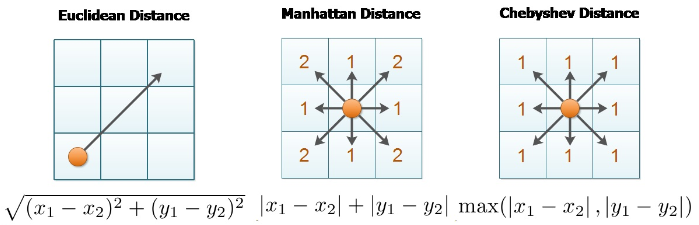

#### GridSpace의 거리는 기본적으로 chebyshev distance(쳬비셰프 거리)를 사용

### DirectDistance
DirectDistance는 이동시 거리에 비례하는 비용이 발생하는데  폰노이만 이웃인 경우는 수직방향의 이웃으로만 이동가능 하기 때문에 1의 비용이 들고 대각선이 허용되는 무어 이웃으로 이동 가능 한경우는 수직은 1,2D 대각선은 √2 , 3D 대각선은 √3 의 비용이 든다.
단 `DirectDistance{D}()`function은 10을 곱값에 정수값만 취한다.

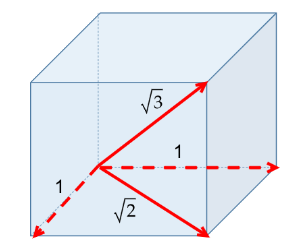

* 예) √2 ~ 1.41,  √3 ~ 1.73

* 예) D가 3인 경우 
```
DirectDistance{3}(
  direction_costs=[10, 14, 17],
)
```

```julia
struct DirectDistance{D} <: CostMetric{D}
    direction_costs::Vector{Int}
end

DirectDistance{D}() where {D} = DirectDistance{D}([floor(Int, 10.0 * √x) for x in 1:D])
```

-------------------------

### PenaltyMap

두 위치 사이의 거리는 두 위치 사이의 최단 거리와 페널티의 절대 차이의 합입니다.

```julia
struct PenaltyMap{D} <: CostMetric{D}
    base_metric::CostMetric{D}
    pmap::Array{Int,D}
end

PenaltyMap(pmap::Array{Int,D}) where {D} = PenaltyMap{D}(DirectDistance{D}(), pmap)

PenaltyMap(pmap::Array{Int,D}, base_metric::CostMetric{D}) where {D} =
    PenaltyMap{D}(base_metric, pmap)

```

-------------------------

### AStar
```julia
struct AStar{D,P,M,T,C<:CostMetric{D}} <: GridPathfinder{D,P,M}
    agent_paths::Dict{Int,Path{D,T}}
    dims::NTuple{D,T}
    neighborhood::Vector{CartesianIndex{D}}
    admissibility::Float64
    walkmap::BitArray{D}
    cost_metric::C
end
```
-------------------------
* `diagonal_movement` : 대각선 방향으로 움직일 수 있는지 여부
 - true   : 대각선에 있는 이웃 타일로 움직일 수 있다.
 - false : 서로 직각인 방향으로만 움직인다.
 - GridSpace에만 적용된다.
 
* `admissibility` : 경로찾기 속도를 높이기 위해 알고리즘이 근사치 경로를 구할 수 있도록 허용

* `walkmap` : 공간에서 이동할 수 있는 위치인지 아닌지 나타낸다.
   - `GridSpace`에 해당하는 크기와 동일한 `BitArray`가 되며 기본적으로 Agent는 공간의 어디에나 갈 수 있다.

* `cost_metric` : 주어진 D 차원의 두점간의 거리를 근사하는데 사용되는 metric으로
`diagonal_movement`이 true 이고 CostMetric이 DirectDistance 인 경우 DirectDistance의 값은 D 차원만큼 존재 해야 한다. D=2 즉 2차원인 DirectDistance{2}값은 예를 [10,14]와 같이 2개가 있어야 한다. 이는 직각 방향으로 움직이는 경우는 cost가 10이 사용되고 대각선 방향으로 움직이면 14가 사용된다는 의미이다. `diagonal_movement`이 false인 경우는 D 값 즉 차원에 관계 없이 DirectDistance의 값중 1번째만 사용된다. 대각선 방향의 움직임이 없고 오직 수직 방향만 있기 때문

```julia
function AStar(
    dims::NTuple{D,T};
    periodic::Bool = false,
    diagonal_movement::Bool = true,
    admissibility::Float64 = 0.0,
    walkmap::BitArray{D} = trues(dims),
    cost_metric::CostMetric{D} = DirectDistance{D}(),
) where {D,T}
    
    # 대각선 방향으로 이동 여부에 따라 무어(대각선 허용 이웃) 또는 
    # 폰노이만 이웃(서로 수직인 이웃)을 리턴한다.
    neighborhood = diagonal_movement ? moore_neighborhood(D) : vonneumann_neighborhood(D)
    return AStar{D,periodic,diagonal_movement,T,typeof(cost_metric)}(
        Dict{Int,Path{D,T}}(),
        dims,
        neighborhood,
        admissibility,
        walkmap,
        cost_metric,
    )
end

# 예) AStar{2, true, true, Int64, DirectDistance{2}}(...)
```
--------------------------
### pathfinding_utils

In [13]:
let
    D=2
    hypercube = CartesianIndices((repeat([-1:1], D)...,))
    @show hypercube
    @show [β for β ∈ hypercube]
    β = CartesianIndex(-1,0);
    @show β.I
    # 대각선 방향 제외하고 서로 수직인 방향만 선택 길이는 1
    pprintln( [β for β ∈ hypercube if LinearAlgebra.norm(β.I) == 1])
    pprintln( [β for β ∈ hypercube if abs(+((β.I)...))== 1])
    pprintln( DirectDistance{1}() )
    pprintln( DirectDistance{2}() )
    pprintln( DirectDistance{3}() )
end

hypercube = CartesianIndices((-1:1, -1:1))
[β for β = hypercube] = CartesianIndex{2}[CartesianIndex(-1, -1) CartesianIndex(-1, 0) CartesianIndex(-1, 1); CartesianIndex(0, -1) CartesianIndex(0, 0) CartesianIndex(0, 1); CartesianIndex(1, -1) CartesianIndex(1, 0) CartesianIndex(1, 1)]
β.I = (-1, 0)
[
  CartesianIndex{2}(
    I=(0, -1),
  ),
  CartesianIndex{2}(
    I=(-1, 0),
  ),
  CartesianIndex{2}(
    I=(1, 0),
  ),
  CartesianIndex{2}(
    I=(0, 1),
  ),
]
[
  CartesianIndex{2}(
    I=(0, -1),
  ),
  CartesianIndex{2}(
    I=(-1, 0),
  ),
  CartesianIndex{2}(
    I=(1, 0),
  ),
  CartesianIndex{2}(
    I=(0, 1),
  ),
]
DirectDistance{1}(
  direction_costs=[10,],
)
DirectDistance{2}(
  direction_costs=[10, 14],
)
DirectDistance{3}(
  direction_costs=[10, 14, 17],
)


In [32]:
let
    space = ContinuousSpace((100. ,100. , 50.); periodic = false)
    heightmap = floor.(Int,convert.(Float64,load(heightmap_path)) *39 ) .+ 1
    cost_metric = PenaltyMap(heightmap, MaxDistance{2}())
    pprintln(cost_metric)
    @show cost_metric
    @show cost_metric.base_metric
    display(cost_metric.pmap)
end

PenaltyMap{2}(
  base_metric=MaxDistance{2}(),
  pmap=Matrix{Int64}(),
)
cost_metric = HeightMap with base: MaxDistance
cost_metric.base_metric = MaxDistance


205×205 Matrix{Int64}:
  2   2   2   2   2   2   2   2   2  …   2   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2  …   3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   3
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   3   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   3   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   3   4   4   4
  2   2   2   2   2   2   2   2   2  …   3   3   3   3   3   3   4   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   4   4   4   4
  2   2   2   2   2   2   2   2   2      3   3   3   3   3   4   4   4   4
  

In [38]:
let
    # Tuple(zeros(Int,D)) : D차원의 0점 예) 2인 경우 (0,0)
    # 원점을 제외한 좌표점
    moore_neighbor(D) = [
        CartesianIndex(a) 
        for a in Iterators.product([-1:1 for ϕ in 1:D]...) if a != Tuple(zeros(Int,D))
    ]
    
    
    function vonneumann_neighborhood(D)
        hypercube = CartesianIndices((repeat([-1:1], D)...,))
        [β for β ∈ hypercube if LinearAlgebra.norm(β.I) == 1]
    end
    
    display("===moore_neighbor(2)===")
    display(moore_neighbor(2))
    
    display("===vonneumann_neighborhood(2)===")
    display(vonneumann_neighborhood(2))
    
 end

"===moore_neighbor(2)==="

8-element Vector{CartesianIndex{2}}:
 CartesianIndex(-1, -1)
 CartesianIndex(0, -1)
 CartesianIndex(1, -1)
 CartesianIndex(-1, 0)
 CartesianIndex(1, 0)
 CartesianIndex(-1, 1)
 CartesianIndex(0, 1)
 CartesianIndex(1, 1)

"===vonneumann_neighborhood(2)==="

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(0, -1)
 CartesianIndex(-1, 0)
 CartesianIndex(1, 0)
 CartesianIndex(0, 1)

In [16]:
function initialize_model(
        heightmap_path = "../img/rabbit_fox_hawk_heightmap.png",
        water_level = 8,
        grass_level = 20,
        mountain_level = 35;
        n_rabbits = 160,
        n_foxes=30,
        n_hawks = 30,
        Δe_grass = 25, ## energy gained from eating grass
        Δe_rabbit = 30, ## energy gained from eating one rabbit
        rabbit_repr = 0.06,
        fox_repr = 0.03,
        hawk_repr = 0.02,
        rabbit_vision = 6,
        fox_vision = 10,
        hawk_vision = 15,
        rabbit_speed = 1.3,
        fox_speed = 1.1,
        hawk_speed = 1.2,
        regrowth_chance = 0.03, ## probability that a patch of grass regrows at any step
        dt = 0.1, ## discrete timestep each iteration of the model
        seed = 42,
)
    # load height map
    # height map : 0 ~ 1 => 1 ~ 40 으로 만듬
    # scaled from 1 to 40
    heightmap = floor.(Int, convert.(Float64, load(heightmap_path)) * 39 ) .+ 1
    # x,y dimensions of the pathfinder are that of the heightmap
    # (205, 205, 50)
    dims = (size(heightmap)...,50)
    ## 각 동물별 접근가능한 맵영역은 `BitArray`로 표현
    land_walkmap = BitArray(falses(dims...))
    air_walkmap = BitArray(falses(dims...))
    for i in 1:dims[1], j in 1:dims[2]
        # land animals can only walk on top of the terrian between 
        # `water_level` and `grass_level`
        # 지상동물이 머물수 있는 공간정의
        if water_level < heightmap[i,j] < grass_level
            land_walkmap[i,j,heightmap[i,j]+1] = true
        end
        # air animals can fly at any height upto `mountain_level`
        if heightmap[i,j] < mountain_level
            air_walkmap[i,j,(heightmap[i,j]+1):mountain_level] .= true
        end
    end
    
    # Generate the RNG for the model
    rng = MersenneTwister(seed)
    
    # 공간의 차원은 pathfinder의 차원과 동일할 필요는 없다
    # 이산(discretisation)방법이 경로찾기에 사용된다.
    space = ContinuousSpace((100. ,100. , 50.); periodic = false)            
    
    # 난수 배열을 생성하고 해당 위치에서 풀이 자랄 확률로 임계값을 지정.
    grass = BitArray(
        rand(rng, dims[1:2]...) .< ((grass_level .- heightmap) ./ (grass_level - water_level)) .< 1,
    )
    properties = (
        ## The pathfinder for rabbits and foxes
        landfinder = AStar(space; walkmap = land_walkmap),
        ## The pathfinder for hawks
        airfinder = AStar(space; walkmap = air_walkmap, cost_metric = MaxDistance{3}()),
        Δe_grass = Δe_grass,
        Δe_rabbit = Δe_rabbit,
        rabbit_repr = rabbit_repr,
        fox_repr = fox_repr,
        hawk_repr = hawk_repr,
        rabbit_vision = rabbit_vision,
        fox_vision = fox_vision,
        hawk_vision = hawk_vision,
        rabbit_speed = rabbit_speed,
        fox_speed = fox_speed,
        hawk_speed = hawk_speed,
        heightmap = heightmap,
        grass = grass,
        regrowth_chance = regrowth_chance,
        water_level = water_level,
        grass_level = grass_level,
        dt = dt,
    )
    model = ABM(Animal, space; rng, properties)
    ## 각 동물을 걸을 수 있는 무작위 위치에 생성한다.
    for _ in 1:n_rabbits
        add_agent_pos!(
            Rabbit(
                nextid(model),
                # 동물이 갈 수 있는 임의의 위치에 생성
                random_walkable(model, model.landfinder),
                rand(model.rng,Δe_grass:2Δe_grass)
            ),
            model
        )
    end
    for _ in 1:n_foxes
        add_agent_pos!(
            Fox(
                nextid(model),
                random_walkable(model, model.landfinder),
                rand(model.rng,Δe_rabbit:2Δe_rabbit),                
            ),
            model
        )
    end
    for _ in 1:n_hawks
        add_agent_pos!(
            Hawk(
                nextid(model),
                random_walkable(model, model.airfinder),
                rand(model.rng, Δe_rabbit:2Δe_rabbit)
            ),
            model
        )
    end
    return model
end

initialize_model (generic function with 5 methods)

In [17]:
# initialize_model()

### animal_step!
* agent 타입에 맞는 `animal_step!` 함수가  호출된다.
* 각 agent에 맞는 step함수는 서로 유사하다.
* agent는 매 스텝마다 에너지를 소모하고 에너지가 0이 되면 죽는다.
* agent는 매 iteration마다 무작위 확률로 자식을 재생산 한다.
* agent는 모두 먹잇감을 향해 움직인다. 토끼의 경우 포식자가 주변에 있는 경우 달아 난다.


In [18]:
function animal_step!(animal::Animal, model::ABM)
    if animal.type == :rabbit
        rabbit_step!(animal,model)
    elseif animal.type == :fox
        fox_step!(animal,model)
    else
        hawk_step!(animal, model) 
    end
end

animal_step! (generic function with 1 method)

### rabbit_step!
* 토끼는 자신의 위치에 있는 풀이 있으면 먹는다
* 토끼가 포식자를 볼 경우 달아 난다.
* 토끼가 도망가는 방향은 토끼의 시야에 있는 모든 포식자의 위치에 달려 있는데 토끼가 있는 위치에 가까울 수록 더 많은 영향을 미친다.
    * 영향도(힘)는 토끼와 포식자 간의 거리의 제곱에 반비례 하도록 한다 중력, 전자력의 세기가 거리의 제곱에 반비례 하는것 처럼
* 토끼의 시야에 포식자가 없으면 무작위로 돌아 다닌다.

In [19]:
function rabbit_step!(rabbit::Animal, model::ABM)
    # 지금 위치에 풀이 있어면 먹는다.
    if get_spatial_property(rabbit.pos, model.grass,model) == 1
        # 풀을 먹었기 때문에 풀이 없음을 표시
        model.grass[get_spatial_index(rabbit.pos,model.grass,model)] = 0
        # 풀을먹고 에너지를 얻는다.
        rabbit.energy += model.Δe_grass
    end
    
    # 매 스텝마다 에너지 소모는 마지막 스템이후 경과한 시간에 달려 있다.
    rabbit.energy -= model.dt
    
    # 모든 동물은 에너지가 0이 되면 죽는다.
    if rabbit.energy <= 0
        kill_agent!(rabbit,model, model.landfinder)
        return
    end
    
    # 주변에 있는 모든 포식자의 위치를 가져온다.
    predators = [
        x.pos for x in nearby_agents(rabbit, model, model.rabbit_vision)
            if x.type == :fox || x.type == :hawk
    ]
    
    # 주변에 포식자가 있고 아직 어딘가로 움직이지 않은 경우
    # 즉 토끼가 경로에 없는 경우
    if !isempty(predators) && is_stationary(rabbit, model.landfinder)
        # 포식자로 부터 멀어 지는 이상적인 방향을 찾고자 한다.
        direction = (0., 0., 0.)
        # 근처에 있는 모든 포식자의 위치에 따른 영향도(힘)를 전부 더 해서
        # 방향을 결정 한다.
        for predator in predators
            # 포식자로 부터 멀어지는 방향을 얻는다.
            # 토끼(r̂)기준에서 포식자(p̂)까지 거리 벡터 d̂은 p̂ - r̂ 인데
            # 토끼는 포식자에서 부터 반대 방향으로 멀어지는 방향으로
            # 거리벡터는 -d̂ 이므로 r̂ - p̂ 이다.
            away_direction = (rabbit.pos .- predator)
            
            # 포식자가 이미 토끼가 있는 위치에 있다면 토끼가 어느방향으로 가든
            # 영향을 미치지 않으므로 방향을 정하는데 기여도가 없다
            all(away_direction .≈ 0.) && continue
            
            # 포식자가 가까이 있을 수록 멀어지는 방향으로 움직이는데 
            # 더 많은 기여를 한다.
            # 여기서 `eunorm(away_direction)^2` 로 제곱하는 이유는
            # 마치 중력이나 전자기력의 세기가 거리의 제곱에 반비례 하는 것과
            # 유사하게 하기 위해서 이다. 가까울 수록 힘이 세게 작용하고
            # 멀리 있는 것에는 힘이 미미 하게 작용한다.            
            direction = direction .+ away_direction ./ eunorm(away_direction)^2
        end
        
        # 유일한 포식자가 토끼 바로 위에 있다면
        # 포식자와의 거리가 거의 0인 경우
        if all(direction .≈ 0.)
            # 토끼의 시야에 있는 임의의 위치로 이동 방향을 잡으면 된다.
            chosen_position = 
                random_walkable(rabbit.pos,model.landfinder,model.rabbit_vision)
        # 포식자와의 거리가 0이 아닌 경우
        else
            # 결정된 방향을 normalize하고 normalize 방향을 이동하기에 
            # 이상적인 위치로 설정
            direction = direction ./ eunorm(direction)
            
            # 포식자에게서 멀리 떨어진 일반적인 방향으로 임의의 위치로 이동합니다.
            # 토끼의 위치에서 정해진 방향으로 토끼의 시야의 절반 거리에 
            # 위치를 설정한다. 그리로 그 설정된 위치에서 토끼 시야의 절반 영역에
            # 있는 임의 위치(즉 반지름이 시야의 1/4인 구 또는 정육면체 영역안에 
            # 있는 임의 위치)를 최종 선택된 위치로 한다.
            position = rabbit.pos .+ direction .* (model.rabbit_vision / 2.)
            chosen_position = 
                random_walkable(position,model,
                    model.landfinder,model.rabbit_vision/2)
        end
        # 선택된 위치까지의 최적 경로를 구한다.
        plan_route!(rabbit, chosen_position,model.landfinder)
    end
    
    # 매 스텝 경과 시간에 비례하는 임의의 확률로 재생산 한다. 
    rand(model.rng) <= model.rabbit_repr * model.dt && reproduce!(rabbit,model)
    
    # 포식자가 없는 경우
    # 토끼가 이미 다른곳으로 이동하지 않았다면 임의 위치로 이동
    if is_stationary(rabbit, model.landfinder)
        plan_route!(
            rabbit,
            random_walkable(rabbit.pos, model, model.landfinder,
                model.rabbit_vision),
            model.landfinder
        )
    end
    
    # 위에서 구한 경로를 따러 움직인다.
    move_along_route!(rabbit, model, model.landfinder,
        model.rabbit_speed, model.dt)
end

rabbit_step! (generic function with 1 method)

### fox_step!
* 여우는 토끼를 사냥하며 자신의 위치에서 단위 반경 이내의 토끼를 잡아먹는다.

In [20]:
function fox_step!(fox::Animal, model::ABM)
    # 먹을 수 있는 근처의 토끼를 찾는다
    food = [x for x in nearby_agents(fox, model) if x.type == :rabbit]
    if !isempty(food)
        # 찾은 토끼들 중 임의의 토끼를 먹는다.
        kill_agent!(rand(model.rng, food), model, model.landfinder)
        fox.energy += model.Δe_rabbit
    end
    
    # 매 스텝 에너비소요량은 마지막 스텝 이후 경과한 시간에 해당 한다.
    fox.energy -= model.dt
    
    # 모든 동물은 에너지가 0 이되면 죽는다.
    if fox.energy <= 0
        kill_agent!(fox, model, model.landfinder)
        return
    end
    
    # 매 스텝마다 재생산의 기회를 갖는다.
    rand(model.rng) <= model.fox_repr * model.dt && reproduce!(fox, model)
    
    # 여우가 이미 어디론가 움직이지 않았다면
    if is_stationary(fox, model.landfinder)
        # 근처에 토끼가 있는지 살펴본다.
        prey = [x for x in nearby_agents(fox, model, model.fox_vision)
                if x.type == :rabbit]
        
        # 토끼가 근처에 없다면 여우는 근처 임의의 위치로 이동할 경로를 찾는다.        
        if isempty(prey)
            plan_route!(
                fox,
                random_walkable(fox.pos, model, model.landfinder,
                    model.fox_vision),
                model.landfinder,
            )
        else
            # 근처에 있는 임의의 토끼를 향한 경로를 찾는다.
            plan_route!(fox, rand(model.rng, map(x->x.pos,prey)),model.landfinder)
        end        
    end
    # 정해진 경로를 따라 fox_speed로 움직인다.
    move_along_route!(fox, model, model.landfinder, model.fox_speed, model.dt)
end

fox_step! (generic function with 1 method)

### hawk_step!
* Hawk(매) step은 매가 날수 있다는점만 다르고 여우의 fox_step!과 유사하다.
* 매는 먹이를 향해 아래로 내려가서 먹이를 먹고 날아 간다.

In [21]:
function hawk_step!(hawk::Animal, model::ABM)
    # 근처에 토끼가 있는지 살펴 본다.
    food = [x for x in nearby_agents(hawk, model) if x.type == :rabbit]
    if !isempty(food)
        # 토끼를 먹는다(kill)
        kill_agent!(rand(model.rng, food), model, model.airfinder)
        hawk.energy += model.Δe_rabbit
        # 날아 간다.
        plan_route!(hawk, hawk.pos .+ (0., 0., 7.), model.airfinder)
    end
    
    # 나머지 step function은 여우와 비슷하지만 매가 다른  pathfinder를 사용
    # 한다는 점만 다르다.
    hawk.energy -= model.dt
    if hawk.energy <= 0
        kill_agent!(hawk, model, model.airfinder)
        return
    end
    
    rand(model.rng) <= model.hawk_repr * model.dt && reproduce!(hawk, model)
    
    if is_stationary(hawk, model.airfinder)
        prey = [x for x in nearby_agents(hawk, model, model.hawk_vision)
                if x.type == :rabbit]
        if isempty(prey)
            plan_route!(
                hawk,
                random_walkable(hawk.pos, model, model.airfinder,
                    model.hawk_vision),
                model.airfinder,
            )
        else
            plan_route!(hawk, rand(model.rng, map(x->x.pos,prey)), model.airfinder)
        end
    end
    move_along_route!(hawk, model, model.airfinder, model.hawk_speed, model.dt)
end

hawk_step! (generic function with 1 method)

### reproduce!
* 이 함수는 동물들이 재생산할 때 사용되는데 재생산시 동물의 에너지는 1/2로 줄어 들고 해당 동물의 복사본이 생산되고 모델에 추가 된다.

In [22]:
function reproduce!(animal::Animal, model::ABM)
    animal.energy = Float64(ceil(Int, animal.energy / 2))
    add_agent_pos!(Animal(nextid(model), animal.pos, v0, animal.type,
                animal.energy), model)
end

reproduce! (generic function with 1 method)

### model_step!
* 이 함수는 풀이 자라는것을 시뮬레이션 한다.

In [23]:
function model_step!(model::ABM)
    # 데이터의 복사본이 생기는 것을 방지 하기 위해 풀을 전혀 가지고 있지 않은
    # grass matrix 파트의 뷰를 얻는다. 
    growable = view(
        model.grass,
        model.grass .== 0 .& model.water_level .< model.heightmap .<= model.grass_level,        
    )
    # 풀은 주어진 확률에 따라 자라는데 확률은  모델의 매 스템마다 경과한 시간에
    # 비례한다.
    growable .= rand(model.rng, length(growable)) .< model.regrowth_chance * model.dt
end

model_step! (generic function with 1 method)

In [24]:
animalcolor(a) = 
    if a.type == :rabbit
        :brown
    elseif a.type == :fox
        :orange
    else
        :blue
    end

animalcolor (generic function with 1 method)

In [25]:
function static_preplot!(ax, model)
    surface!(
        ax,
        (100/205):(100/205):100,
        (100/205):(100/205):100,
        model.heightmap;
        colormap = :terrain
    )
end

static_preplot! (generic function with 1 method)

In [27]:
let
    ENV["DISPLAY"]="localhost:13.0"
    using InteractiveDynamics
    using GLMakie
    GLMakie.activate!()
    
    plotkwargs = (;
        figure = (resolution = (800, 700),),
        ac = animalcolor,
        as = 1.0,
        static_preplot!,
        title = "Rabbit Fox Hawk with pathfinding",
    )    
    
    model = initialize_model()

    fig, ax, abmobs = abmplot(model;
        agent_step! = animal_step!,
        model_step! = model_step!,
        plotkwargs...)
   
    display(fig)    
end

GLMakie.Screen(...)

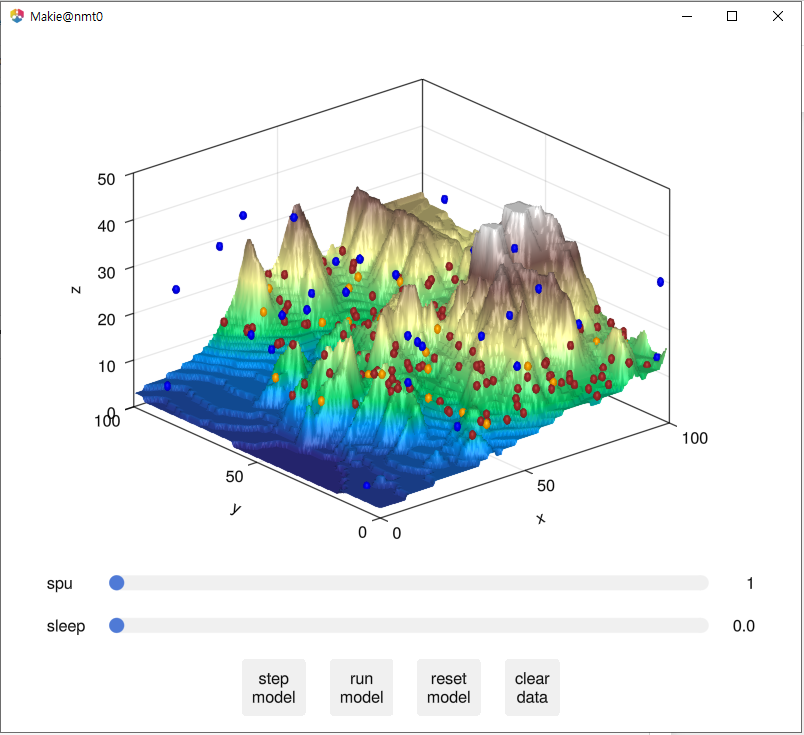

In [28]:
let
    using InteractiveDynamics
    using CairoMakie

    CairoMakie.activate!()
    model = initialize_model()
    abmvideo(
        "rabbit_fox_hawk.mp4",
        model, animal_step!, model_step!;
        figure = (resolution = (800, 700),),
        frames = 300,
        framerate = 15,
        ac = animalcolor,
        as = 1.0,
        static_preplot!,
        title = "Rabbit Fox Hawk with pathfinding"
    )
end

<video width="auto" controls autoplay loop source src="rabbit_fox_hawk.mp4" type="video/mp4"/>
<!-- <video width="auto" controls autoplay loop source src="https://julialang.kr/wp-content/uploads/2022/11/rabbit_fox_hawk-1.mp4" type="video/mp4"/> -->